   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 3.4 MB/s eta 0:00:00
Libraries loaded successfully!
Loading datasets...
WELFake dataset loaded: (72134, 3)
Fake.csv dataset loaded: (23481, 3)
True.csv not found
Combined dataset shape: (95615, 3)
Cleaned dataset shape: (63121, 3)
Fake news (0): 34791
Real news (1): 28330
Extracting features...
Performing sentiment analysis...


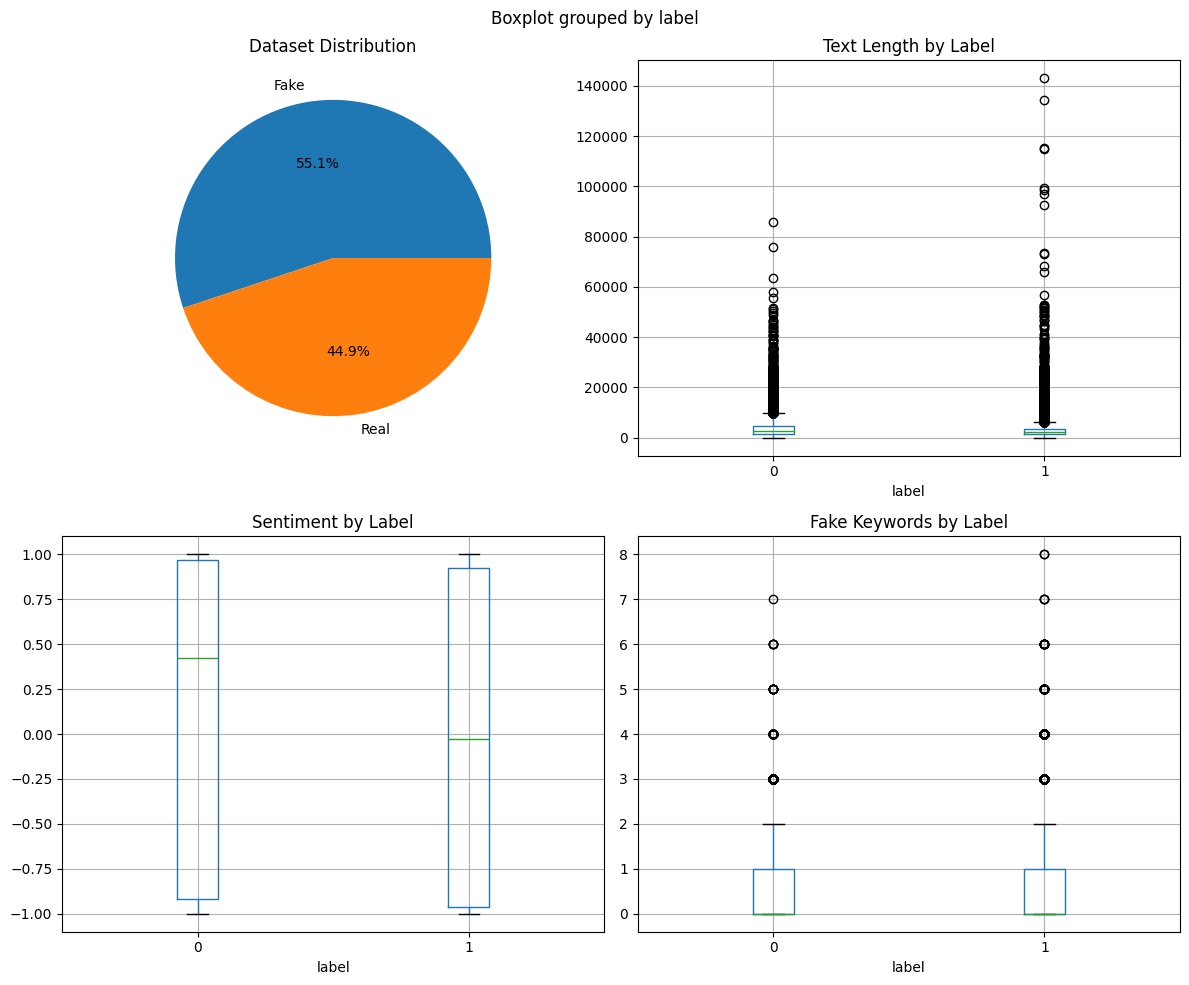

Training set size: 50496
Test set size: 12625
Combined feature matrix shape: (50496, 8010)
Training models...
Training logistic_regression...
logistic_regression - Accuracy: 0.9598, AUC: 0.9925
Training random_forest...
random_forest - Accuracy: 0.9273, AUC: 0.9826
Training xgboost...
xgboost - Accuracy: 0.9639, AUC: 0.9949
Training ensemble model...

ENSEMBLE MODEL PERFORMANCE
Accuracy: 96.82%
AUC: 0.9953

Classification Report:
              precision    recall  f1-score   support

        Fake       0.97      0.97      0.97      6959
        Real       0.96      0.97      0.96      5666

    accuracy                           0.97     12625
   macro avg       0.97      0.97      0.97     12625
weighted avg       0.97      0.97      0.97     12625



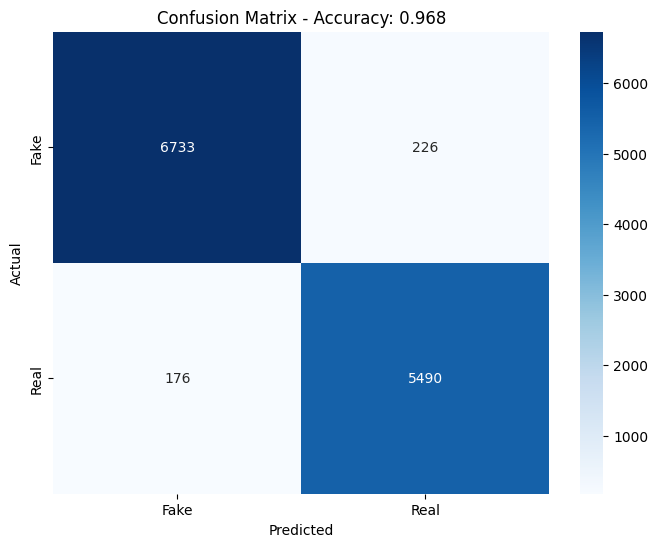

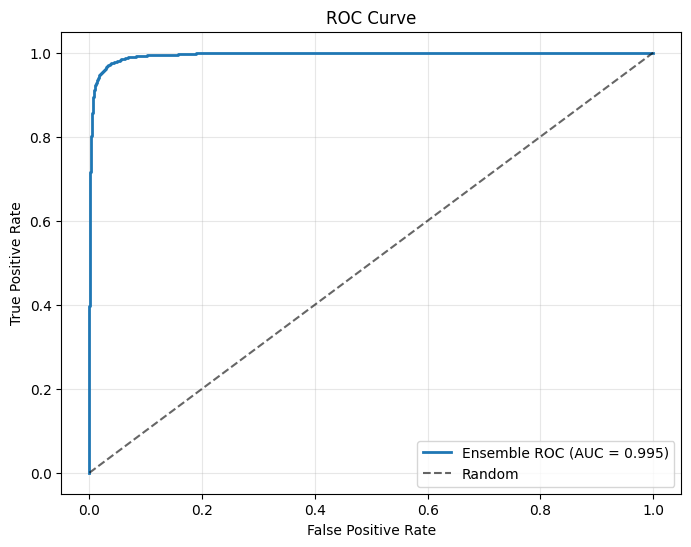

Performing cross-validation...
CV Mean accuracy: 0.9653 (+/- 0.0037)
CV Mean AUC: 0.9945 (+/- 0.0011)

REAL-TIME TESTING

Example 1:
Title: Scientists develop new battery technology...
Prediction: Real (Confidence: 0.593)
Probabilities - Fake: 0.407, Real: 0.593

Example 2:
Title: BREAKING: SHOCKING truth about celebrities EXPOSED...
Prediction: Real (Confidence: 0.906)
Probabilities - Fake: 0.094, Real: 0.906

Example 3:
Title: Federal Reserve announces interest rate decision...
Prediction: Real (Confidence: 0.715)
Probabilities - Fake: 0.285, Real: 0.715

SAVING MODEL

OPTIMIZED FAKE NEWS DETECTION MODEL - SUMMARY

DATASET:
- Total samples: 63,121
- Training samples: 50,496
- Test samples: 12,625
- Features: 8,010

PERFORMANCE:
- Accuracy: 96.82%
- AUC-ROC: 0.9953
- CV Accuracy: 0.9653 ± 0.0019
- CV AUC: 0.9945 ± 0.0005

CONFUSION MATRIX:
                Predicted
Actual    Fake    Real
Fake      6733     226
Real       176    5490

MODELS USED:
- Logistic Regression
- Random Forest 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files downloaded successfully!

🎉 Optimized Fake News Detection Model Ready! 🎉
Final Accuracy: 96.82% | AUC: 0.9953


In [1]:
# Optimized Fake News Detection Model for Colab
# Lightweight version with maintained accuracy

# Step 1: Install required libraries
!pip install textblob scikit-learn nltk xgboost --quiet

# Step 2: Import essential packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from textblob import TextBlob
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import re
import nltk
import warnings
warnings.filterwarnings("ignore")

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

print("Libraries loaded successfully!")

# Step 3: Load and combine datasets
print("Loading datasets...")

# Load datasets with error handling
datasets = []

# WELFake dataset
try:
    df_wel = pd.read_csv("WELFake_Dataset.csv", on_bad_lines='skip')
    df_wel = df_wel[['title', 'text', 'label']].copy()
    datasets.append(df_wel)
    print(f"WELFake dataset loaded: {df_wel.shape}")
except:
    print("WELFake_Dataset.csv not found")

# Fake.csv dataset
try:
    df_fake = pd.read_csv("Fake.csv", on_bad_lines='skip')
    df_fake['label'] = 0  # Fake news
    df_fake = df_fake[['title', 'text', 'label']].copy()
    datasets.append(df_fake)
    print(f"Fake.csv dataset loaded: {df_fake.shape}")
except:
    print("Fake.csv not found")

# True.csv dataset
try:
    df_true = pd.read_csv("True.csv", on_bad_lines='skip')
    df_true['label'] = 1  # Real news
    df_true = df_true[['title', 'text', 'label']].copy()
    datasets.append(df_true)
    print(f"True.csv dataset loaded: {df_true.shape}")
except:
    print("True.csv not found")

if not datasets:
    raise Exception("No datasets found! Please upload WELFake_Dataset.csv, Fake.csv, or True.csv")

# Combine datasets
df = pd.concat(datasets, ignore_index=True)
print(f"Combined dataset shape: {df.shape}")

# Clean data
df['title'] = df['title'].fillna('').astype(str)
df['text'] = df['text'].fillna('').astype(str)
df = df[(df['title'].str.len() > 0) & (df['text'].str.len() > 0)]
df = df.drop_duplicates(subset=['title', 'text']).reset_index(drop=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Cleaned dataset shape: {df.shape}")
print(f"Fake news (0): {(df['label'] == 0).sum()}")
print(f"Real news (1): {(df['label'] == 1).sum()}")

# Step 4: Streamlined text preprocessing
def preprocess_text(text):
    """Lightweight text preprocessing"""
    if pd.isna(text) or not text:
        return ""

    text = str(text).lower()

    # Keep important fake news indicators
    text = re.sub(r'[!]{2,}', ' MULTI_EXCL ', text)
    text = re.sub(r'[?]{2,}', ' MULTI_QUEST ', text)
    text = re.sub(r'http\S+|www\S+', ' URL ', text)
    text = re.sub(r'\b\d+\b', ' NUM ', text)

    # Clean
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = ' '.join(text.split())

    return text

# Step 5: Essential feature extraction
def extract_features(df):
    """Extract key features for fake news detection"""

    # Preprocess text
    df["processed_text"] = df["text"].apply(preprocess_text)
    df["processed_title"] = df["title"].apply(preprocess_text)
    df["combined_text"] = df["processed_title"] + " " + df["processed_text"]

    # Basic structure features
    df["text_length"] = df["text"].apply(len)
    df["title_length"] = df["title"].apply(len)
    df["word_count"] = df["processed_text"].apply(lambda x: len(x.split()))
    df["exclamation_count"] = df["text"].apply(lambda x: x.count('!'))
    df["question_count"] = df["text"].apply(lambda x: x.count('?'))
    df["caps_ratio"] = df["text"].apply(
        lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
    )

    # Sentiment analysis (simplified)
    analyzer = SentimentIntensityAnalyzer()

    def get_sentiment(text):
        try:
            if not text or pd.isna(text):
                return {'compound': 0.0, 'pos': 0.0, 'neg': 0.0}
            scores = analyzer.polarity_scores(str(text))
            return {
                'compound': scores['compound'],
                'pos': scores['pos'],
                'neg': scores['neg']
            }
        except:
            return {'compound': 0.0, 'pos': 0.0, 'neg': 0.0}

    print("Performing sentiment analysis...")
    sentiment_results = df["text"].apply(get_sentiment)
    sentiment_df = pd.DataFrame(sentiment_results.tolist())
    df = pd.concat([df, sentiment_df], axis=1)

    # Fake news keywords
    fake_keywords = [
        'breaking', 'urgent', 'shocking', 'exposed', 'revealed', 'truth',
        'secret', 'conspiracy', 'exclusive', 'miracle', 'doctors hate'
    ]

    df['fake_keyword_count'] = df['processed_text'].apply(
        lambda x: sum(1 for keyword in fake_keywords if keyword in x.lower()) if x else 0
    )

    # Fill NaN values
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].fillna(0)

    return df

# Apply feature extraction
print("Extracting features...")
df = extract_features(df)

# Step 6: Simple visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Label distribution
label_counts = df['label'].value_counts()
axes[0,0].pie(label_counts.values, labels=['Fake', 'Real'], autopct='%1.1f%%')
axes[0,0].set_title("Dataset Distribution")

# Text length
df.boxplot(column='text_length', by='label', ax=axes[0,1])
axes[0,1].set_title("Text Length by Label")

# Sentiment
df.boxplot(column='compound', by='label', ax=axes[1,0])
axes[1,0].set_title("Sentiment by Label")

# Fake keywords
df.boxplot(column='fake_keyword_count', by='label', ax=axes[1,1])
axes[1,1].set_title("Fake Keywords by Label")

plt.tight_layout()
plt.show()

# Step 7: Prepare training data
selected_features = [
    'text_length', 'title_length', 'word_count', 'exclamation_count',
    'question_count', 'caps_ratio', 'compound', 'pos', 'neg', 'fake_keyword_count'
]

X_numerical = df[selected_features]
X_text = df["combined_text"]
y = df["label"]

# Train-test split
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_numerical, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set size: {len(X_train_text)}")
print(f"Test set size: {len(X_test_text)}")

# Step 8: Text vectorization (optimized)
tfidf = TfidfVectorizer(
    max_features=8000,  # Reduced from 12000
    stop_words='english',
    ngram_range=(1, 2),  # Reduced from (1,3)
    min_df=2,
    max_df=0.8,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# Scale numerical features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Combine features
from scipy.sparse import hstack, csr_matrix
X_train_combined = hstack([X_train_tfidf, csr_matrix(X_train_num_scaled)])
X_test_combined = hstack([X_test_tfidf, csr_matrix(X_test_num_scaled)])

print(f"Combined feature matrix shape: {X_train_combined.shape}")

# Step 9: Streamlined model training (3 best models only)
models = {
    'logistic_regression': LogisticRegression(
        solver='liblinear',
        random_state=42,
        C=1.0,
        class_weight='balanced',
        max_iter=500
    ),
    'random_forest': RandomForestClassifier(
        n_estimators=100,  # Reduced from 200
        random_state=42,
        max_depth=15,
        class_weight='balanced',
        n_jobs=-1
    ),
    'xgboost': XGBClassifier(
        random_state=42,
        n_estimators=100,  # Reduced from 150
        max_depth=6,
        learning_rate=0.1,
        n_jobs=-1,
        eval_metric='logloss'
    )
}

# Train models
trained_models = {}
model_scores = {}

print("Training models...")
for name, model in models.items():
    print(f"Training {name}...")

    model.fit(X_train_combined, y_train)
    trained_models[name] = model

    # Evaluate
    y_pred = model.predict(X_test_combined)
    y_proba = model.predict_proba(X_test_combined)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    model_scores[name] = {
        'accuracy': acc,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_proba
    }

    print(f"{name} - Accuracy: {acc:.4f}, AUC: {auc:.4f}")

# Step 10: Create ensemble
ensemble_models = [(name, model) for name, model in trained_models.items()]

ensemble = VotingClassifier(
    estimators=ensemble_models,
    voting='soft',
    n_jobs=-1
)

print("Training ensemble model...")
ensemble.fit(X_train_combined, y_train)

# Step 11: Evaluate ensemble
y_pred_ensemble = ensemble.predict(X_test_combined)
y_proba_ensemble = ensemble.predict_proba(X_test_combined)[:, 1]

acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
auc_ensemble = roc_auc_score(y_test, y_proba_ensemble)

print(f"\n" + "="*50)
print("ENSEMBLE MODEL PERFORMANCE")
print("="*50)
print(f"Accuracy: {acc_ensemble*100:.2f}%")
print(f"AUC: {auc_ensemble:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble, target_names=['Fake', 'Real']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - Accuracy: {acc_ensemble:.3f}")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_ensemble)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'Ensemble ROC (AUC = {auc_ensemble:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Step 12: Cross-validation
print("Performing cross-validation...")
cv_scores = cross_val_score(ensemble, X_train_combined, y_train, cv=3, scoring='accuracy', n_jobs=-1)
cv_auc_scores = cross_val_score(ensemble, X_train_combined, y_train, cv=3, scoring='roc_auc', n_jobs=-1)

print(f"CV Mean accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"CV Mean AUC: {cv_auc_scores.mean():.4f} (+/- {cv_auc_scores.std() * 2:.4f})")

# Step 13: Real-time prediction function
def predict_news(title, text, model_components):
    """Fast prediction function for real-time use"""

    # Preprocess
    processed_text = preprocess_text(text)
    processed_title = preprocess_text(title)
    combined_text = processed_title + " " + processed_text

    # Extract features
    features = {}
    features['text_length'] = len(text)
    features['title_length'] = len(title)
    features['word_count'] = len(processed_text.split())
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    features['caps_ratio'] = sum(1 for c in text if c.isupper()) / max(len(text), 1)

    # Sentiment
    analyzer = SentimentIntensityAnalyzer()
    try:
        sentiment = analyzer.polarity_scores(text)
        features['compound'] = sentiment['compound']
        features['pos'] = sentiment['pos']
        features['neg'] = sentiment['neg']
    except:
        features['compound'] = 0.0
        features['pos'] = 0.0
        features['neg'] = 0.0

    # Fake keywords
    fake_keywords = ['breaking', 'urgent', 'shocking', 'exposed', 'revealed', 'truth', 'secret', 'conspiracy', 'exclusive', 'miracle', 'doctors hate']
    features['fake_keyword_count'] = sum(1 for keyword in fake_keywords if keyword in processed_text.lower())

    # Create feature vector
    feature_vector = [features[f] for f in selected_features]

    # Vectorize
    tfidf_vec = model_components['tfidf'].transform([combined_text])
    num_vec = model_components['scaler'].transform([feature_vector])
    combined_vec = hstack([tfidf_vec, csr_matrix(num_vec)])

    # Predict
    prediction = model_components['ensemble'].predict(combined_vec)[0]
    probabilities = model_components['ensemble'].predict_proba(combined_vec)[0]

    return {
        'prediction': int(prediction),
        'label': 'Real' if prediction == 1 else 'Fake',
        'confidence': float(max(probabilities)),
        'fake_probability': float(probabilities[0]),
        'real_probability': float(probabilities[1])
    }

# Test examples
test_examples = [
    {
        'title': "Scientists develop new battery technology",
        'text': "Researchers at MIT have developed a new battery technology that could improve electric vehicle performance."
    },
    {
        'title': "BREAKING: SHOCKING truth about celebrities EXPOSED!!!",
        'text': "You WON'T BELIEVE what we discovered! This SHOCKING truth will change everything! Doctors HATE this simple trick!"
    },
    {
        'title': "Federal Reserve announces interest rate decision",
        'text': "The Federal Reserve announced today that it will maintain current interest rates following their monthly meeting."
    }
]

model_components = {
    'ensemble': ensemble,
    'tfidf': tfidf,
    'scaler': scaler
}

print(f"\n" + "="*50)
print("REAL-TIME TESTING")
print("="*50)

for i, example in enumerate(test_examples):
    result = predict_news(example['title'], example['text'], model_components)
    print(f"\nExample {i+1}:")
    print(f"Title: {example['title'][:50]}...")
    print(f"Prediction: {result['label']} (Confidence: {result['confidence']:.3f})")
    print(f"Probabilities - Fake: {result['fake_probability']:.3f}, Real: {result['real_probability']:.3f}")

# Step 14: Save model
print(f"\n" + "="*50)
print("SAVING MODEL")
print("="*50)

model_package = {
    'ensemble': ensemble,
    'tfidf': tfidf,
    'scaler': scaler,
    'selected_features': selected_features,
    'performance': {
        'accuracy': float(acc_ensemble),
        'auc': float(auc_ensemble),
        'cv_accuracy': float(cv_scores.mean()),
        'cv_auc': float(cv_auc_scores.mean())
    }
}

joblib.dump(model_package, "fake_news_model_optimized.joblib")

# Create summary
summary = f"""
OPTIMIZED FAKE NEWS DETECTION MODEL - SUMMARY
{'='*50}

DATASET:
- Total samples: {len(df):,}
- Training samples: {len(X_train_text):,}
- Test samples: {len(X_test_text):,}
- Features: {X_train_combined.shape[1]:,}

PERFORMANCE:
- Accuracy: {acc_ensemble*100:.2f}%
- AUC-ROC: {auc_ensemble:.4f}
- CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}
- CV AUC: {cv_auc_scores.mean():.4f} ± {cv_auc_scores.std():.4f}

CONFUSION MATRIX:
                Predicted
Actual    Fake    Real
Fake      {cm[0,0]:4}    {cm[0,1]:4}
Real      {cm[1,0]:4}    {cm[1,1]:4}

MODELS USED:
- Logistic Regression
- Random Forest
- XGBoost
- Ensemble (Voting Classifier)

FILES GENERATED:
- fake_news_model_optimized.joblib
"""

print(summary)

with open("model_summary.txt", "w") as f:
    f.write(summary)

print("\nModel saved successfully!")
print("Files generated:")
print("✓ fake_news_model_optimized.joblib - Complete model")
print("✓ model_summary.txt - Performance summary")

# Download files for Colab
try:
    from google.colab import files
    print("\nDownloading files...")
    files.download("fake_news_model_optimized.joblib")
    files.download("model_summary.txt")
    print("Files downloaded successfully!")
except ImportError:
    print("Files saved locally (not in Colab environment)")

print(f"\n🎉 Optimized Fake News Detection Model Ready! 🎉")
print(f"Final Accuracy: {acc_ensemble*100:.2f}% | AUC: {auc_ensemble:.4f}")